In [ ]:
%pip install pyspark textblob

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import (
    StructType, StructField, StringType,
    IntegerType, TimestampType
)
from pyspark.sql.functions import col, to_timestamp, udf, count, avg
from pyspark.sql import functions as F
import datetime
import random
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("CustomerFeedbackAnalysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Define schema for feedback data
feedback_schema = StructType([
    StructField("Customer_ID", StringType(), False),
    StructField("Feedback_Channel", StringType(), False),
    StructField("Rating", IntegerType(), False),
    StructField("Comment", StringType(), True),
    StructField("Date", TimestampType(), False)
])

In [ ]:
def generate_spark_data(num_records=1000):
    """Generate sample data in Spark"""
    channels = ["Email", "Social Media", "Survey","Live chat","Interview"]
    comments = ["Too many bugs in the app....", "Too many ads on the platform....", "Love the new updates!", "Fantastic i love it !", "Horrible service to slow!", "Will be recommend !","I faced issues with payment.","Product is overpriced.","I received wrong item."]

    data = []
    current_date = datetime.datetime.now()

    for _ in range(num_records):
        data.append((
            f"C{random.randint(10000, 99999)}",
            random.choice(channels),
            random.randint(1, 5),
            random.choice(comments),
            (current_date - datetime.timedelta(days=random.randint(0, 30)))
        ))

    # Create Spark DataFrame
    return spark.createDataFrame(data, ["Customer_ID", "Feedback_Channel", "Rating", "Comment", "Date"])

# Generate the Spark DataFrame
spark_df = generate_spark_data(1000)
spark_df.show(5)


+-----------+----------------+------+--------------------+--------------------+
|Customer_ID|Feedback_Channel|Rating|             Comment|                Date|
+-----------+----------------+------+--------------------+--------------------+
|     C53781|           Email|     3| Will be recommend !|2024-10-13 05:25:...|
|     C39717|       Live chat|     5|Product is overpr...|2024-10-17 05:25:...|
|     C72307|    Social Media|     3|I received wrong ...|2024-10-28 05:25:...|
|     C82477|           Email|     3|Fantastic i love ...|2024-11-01 05:25:...|
|     C12536|       Live chat|     1|I received wrong ...|2024-10-18 05:25:...|
+-----------+----------------+------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
def spark_to_pandas(spark_df):
    """Convert Spark DataFrame to Pandas DataFrame"""
    try:
        pandas_df = spark_df.toPandas()
        print(f"Successfully converted {len(pandas_df)} records to pandas DataFrame")
        return pandas_df
    except Exception as e:
        print(f"Error converting to pandas: {e}")
        return None

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_to_pandas(spark_df.limit(1000))
print(pandas_df.head())

Successfully converted 1000 records to pandas DataFrame
  Customer_ID Feedback_Channel  Rating                 Comment  \
0      C53781            Email       3     Will be recommend !   
1      C39717        Live chat       5  Product is overpriced.   
2      C72307     Social Media       3  I received wrong item.   
3      C82477            Email       3   Fantastic i love it !   
4      C12536        Live chat       1  I received wrong item.   

                        Date  
0 2024-10-13 05:25:13.786411  
1 2024-10-17 05:25:13.786411  
2 2024-10-28 05:25:13.786411  
3 2024-11-01 05:25:13.786411  
4 2024-10-18 05:25:13.786411  


In [ ]:
def clean_data(df):
    """Clean the feedback comments"""
    # Remove unnecessary characters and handle missing values
    df['Comment'] = df['Comment'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()
    df['Comment'] = df['Comment'].fillna('No Comment')
    return df

# Clean the data
pandas_df = clean_data(pandas_df)

In [ ]:
def analyze_sentiment(comment):
    """Analyze sentiment of the comment"""
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Perform sentiment analysis
sentiment_udf = udf(analyze_sentiment, StringType())
spark_df = spark_df.withColumn("Sentiment", sentiment_udf(col("Comment")))

In [ ]:
def perform_analysis(pandas_df):
    """Perform basic analysis on the pandas DataFrame"""
    if pandas_df is None:
        print("No data available for analysis")
        return None

    analysis = {
        'total_records': len(pandas_df),
        'channel_distribution': pandas_df['Feedback_Channel'].value_counts().to_dict(),
        'average_rating': pandas_df['Rating'].mean(),
        'rating_distribution': pandas_df['Rating'].value_counts().sort_index().to_dict()
    }

    return analysis

# Perform analysis on the processed Pandas DataFrame
analysis = perform_analysis(pandas_df)
if analysis:
    print("\nAnalysis Results:")
    for key, value in analysis.items():
        print(f"{key}: {value}")


Analysis Results:
total_records: 1000
channel_distribution: {'Email': 218, 'Interview': 216, 'Social Media': 215, 'Live chat': 180, 'Survey': 171}
average_rating: 2.967
rating_distribution: {1: 196, 2: 218, 3: 190, 4: 215, 5: 181}


In [ ]:
# Trend analysis
def trend_analysis(spark_df):
    """Analyze trends over time and by channel"""
    # Convert date to date format
    spark_df = spark_df.withColumn("Date", to_timestamp(col("Date")))

    # Average ratings per channel
    avg_rating_per_channel = spark_df.groupBy("Feedback_Channel").agg(avg("Rating").alias("Average_Rating"))
    avg_rating_per_channel.show()

    # Count of sentiments by channel
    sentiment_distribution = spark_df.groupBy("Feedback_Channel", "Sentiment").agg(count("Sentiment").alias("Count"))
    sentiment_distribution.show()

    # Generate plots
    return avg_rating_per_channel, sentiment_distribution

avg_rating_per_channel, sentiment_distribution = trend_analysis(spark_df)

+----------------+------------------+
|Feedback_Channel|    Average_Rating|
+----------------+------------------+
|           Email|2.9128440366972477|
|    Social Media|3.0093023255813955|
|       Live chat|2.9833333333333334|
|       Interview| 2.962962962962963|
|          Survey|2.9707602339181287|
+----------------+------------------+

+----------------+---------+-----+
|Feedback_Channel|Sentiment|Count|
+----------------+---------+-----+
|       Live chat| Negative|   43|
|    Social Media| Negative|   46|
|           Email|  Neutral|   73|
|    Social Media|  Neutral|   82|
|       Live chat|  Neutral|   61|
|           Email| Positive|   99|
|          Survey| Positive|   83|
|       Interview|  Neutral|   74|
|       Interview| Positive|   96|
|    Social Media| Positive|   87|
|          Survey| Negative|   34|
|       Live chat| Positive|   76|
|       Interview| Negative|   46|
|           Email| Negative|   46|
|          Survey|  Neutral|   54|
+----------------+---------

In [ ]:
# Visualization Functions
def visualize_sentiment_distribution(sentiment_distribution):
    """Visualize sentiment distribution"""
    sentiment_pd = sentiment_distribution.toPandas()
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feedback_Channel', y='Count', hue='Sentiment', data=sentiment_pd)
    plt.title('Sentiment Distribution by Feedback Channel')
    plt.ylabel('Count of Sentiments')
    plt.xlabel('Feedback Channel')
    plt.legend(title='Sentiment')
    plt.show()


In [ ]:
def visualize_average_ratings(avg_rating_per_channel):
    """Visualize average ratings by feedback channel"""
    avg_rating_pd = avg_rating_per_channel.toPandas()
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feedback_Channel', y='Average_Rating', data=avg_rating_pd)
    plt.title('Average Ratings by Feedback Channel')
    plt.ylabel('Average Rating')
    plt.xlabel('Feedback Channel')
    plt.ylim(0, 5)  # Set y-axis limit
    plt.show()


In [ ]:
def visualize_trends_over_time(spark_df):
    """Visualize feedback trends over time"""
    trend_data = spark_df.groupBy(F.to_date(col("Date")).alias("Date")).agg(count("Customer_ID").alias("Feedback_Count"))
    trend_data_pd = trend_data.toPandas()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend_data_pd, x='Date', y='Feedback_Count')
    plt.title('Feedback Trends Over Time')
    plt.ylabel('Number of Feedbacks')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.show()


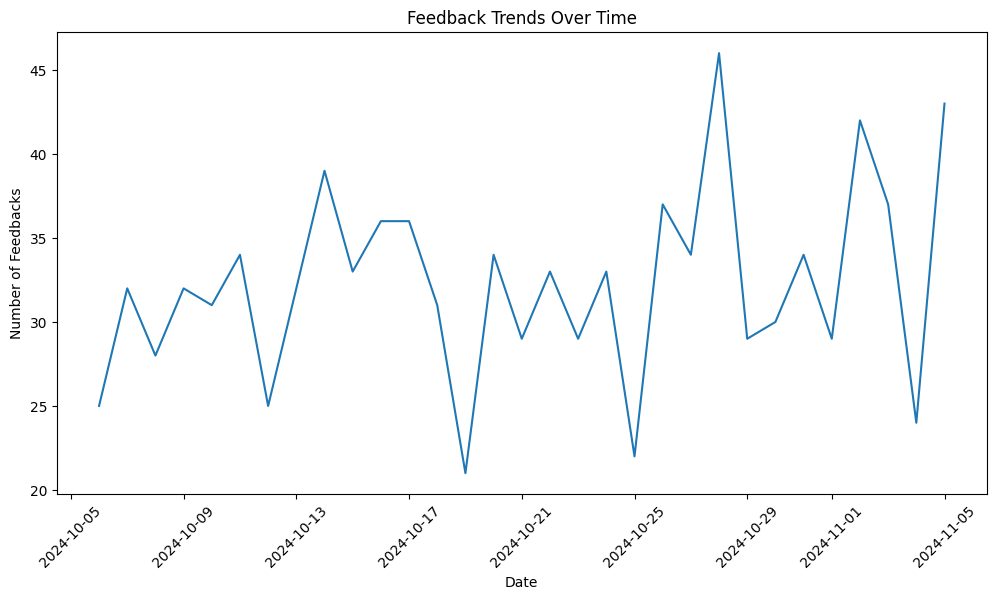

In [ ]:
visualize_trends_over_time(spark_df)

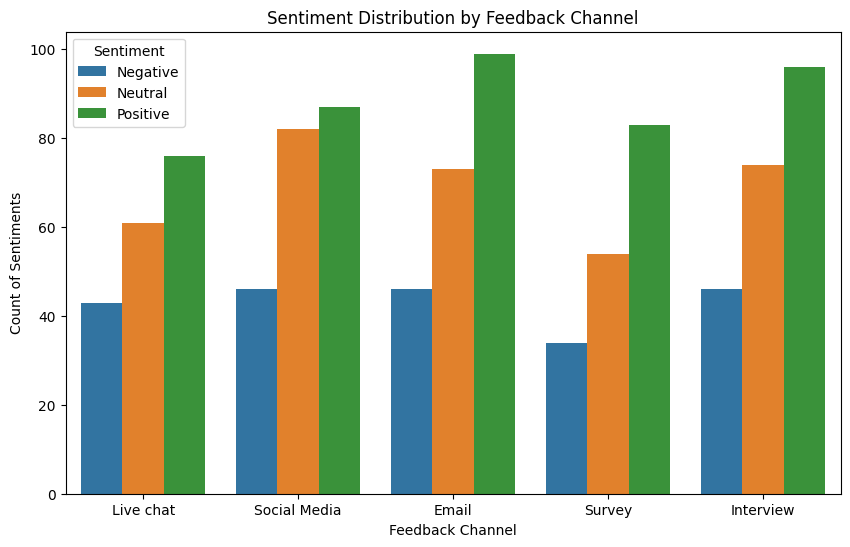

In [ ]:
visualize_sentiment_distribution(sentiment_distribution)

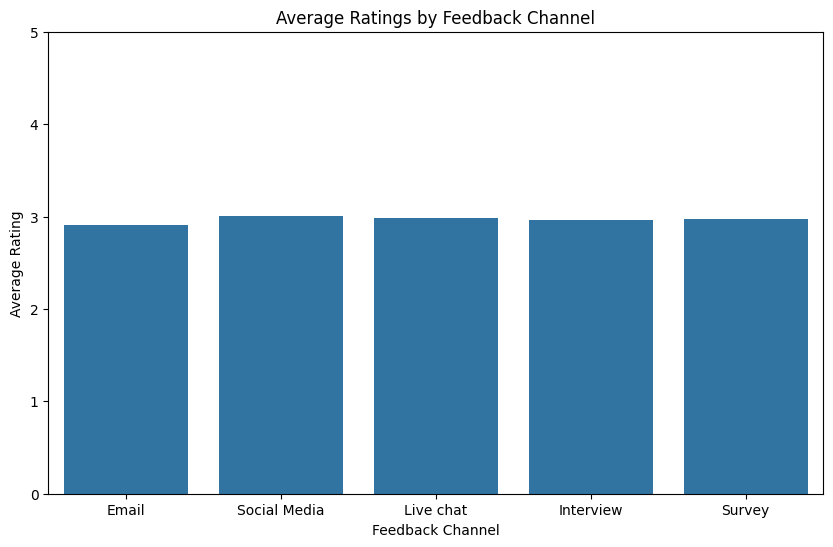

In [ ]:
visualize_average_ratings(avg_rating_per_channel)

In [ ]:
def visualize_average_ratings_as_pie(avg_rating_per_channel):
    """Visualize average ratings by feedback channel as a pie chart with percentage contribution."""
    # Convert to Pandas DataFrame for plotting
    avg_rating_pd = avg_rating_per_channel.toPandas()

    # Calculate total average rating for scaling
    avg_rating_pd['Percentage'] = (avg_rating_pd['Average_Rating'] / avg_rating_pd['Average_Rating'].sum()) * 100

    # Create the pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(avg_rating_pd['Percentage'], labels=avg_rating_pd['Feedback_Channel'], autopct='%1.1f%%', startangle=140)
    plt.title('Average Ratings by Feedback Channel (Percentage)')
    plt.show()

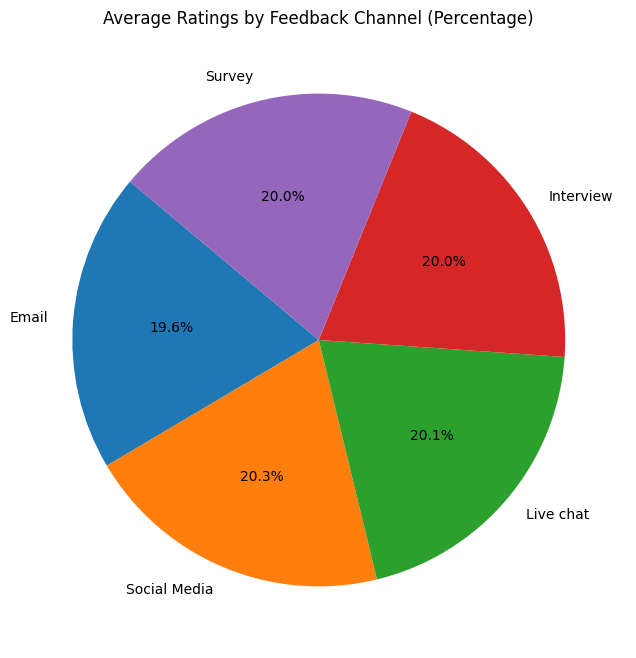

In [ ]:
visualize_average_ratings_as_pie(avg_rating_per_channel)

In [2]:
pip install dash plotly pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.4 MB/s eta 0:00:00


In [5]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import col, to_timestamp, avg, count, udf
from textblob import TextBlob
import dash
from dash import dcc, html
import plotly.express as px
import datetime
import random

# 1. Initialize Spark session
spark = SparkSession.builder \
    .appName("CustomerFeedbackAnalysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# 2. Define schema for feedback data
feedback_schema = StructType([
    StructField("Customer_ID", StringType(), False),
    StructField("Feedback_Channel", StringType(), False),
    StructField("Rating", IntegerType(), False),
    StructField("Comment", StringType(), True),
    StructField("Date", TimestampType(), False)
])

def generate_spark_data(num_records=1000):
    """Generate sample data in Spark"""
    channels = ["Email", "Social Media", "Survey", "Live chat", "Interview"]
    comments = ["Too many bugs in the app....", "Too many ads on the platform....",
                "Love the new updates!", "Fantastic i love it !", "Horrible service to slow!",
                "Will be recommend !", "I faced issues with payment.", "Product is overpriced.",
                "I received wrong item."]

    data = []
    current_date = datetime.datetime.now()

    for _ in range(num_records):
        data.append((
            f"C{random.randint(10000, 99999)}",
            random.choice(channels),
            random.randint(1, 5),
            random.choice(comments),
            (current_date - datetime.timedelta(days=random.randint(0, 30)))
        ))

    # Create Spark DataFrame
    return spark.createDataFrame(data, ["Customer_ID", "Feedback_Channel", "Rating", "Comment", "Date"])

# Generate the Spark DataFrame
spark_df = generate_spark_data(1000)

# 3. Define function for sentiment analysis
def analyze_sentiment(comment):
    """Analyze sentiment of the comment"""
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Perform sentiment analysis
sentiment_udf = udf(analyze_sentiment, StringType())
spark_df = spark_df.withColumn("Sentiment", sentiment_udf(col("Comment")))

# 4. Trend analysis function
def trend_analysis(spark_df):
    """Analyze trends over time and by channel"""
    spark_df = spark_df.withColumn("Date", to_timestamp(col("Date")))

    avg_rating_per_channel = spark_df.groupBy("Feedback_Channel").agg(avg("Rating").alias("Average_Rating"))
    sentiment_distribution = spark_df.groupBy("Feedback_Channel", "Sentiment").agg(count("Sentiment").alias("Count"))

    return avg_rating_per_channel, sentiment_distribution

# Run trend analysis
avg_rating_per_channel, sentiment_distribution = trend_analysis(spark_df)

# 5. Convert Spark DataFrames to Pandas for use in Dash visualizations
avg_rating_per_channel_pd = avg_rating_per_channel.toPandas()
sentiment_distribution_pd = sentiment_distribution.toPandas()

# Prepare data for average rating trend over time
pandas_df = spark_df.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
avg_rating_trend = pandas_df.groupby(pandas_df['Date'].dt.date)['Rating'].mean().reset_index()

# 6. Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the Dashboard
app.layout = html.Div([
    html.H1("Customer Feedback Analysis Dashboard", style={'text-align': 'center'}),

    dcc.Tabs([
        dcc.Tab(label='Sentiment Distribution by Channel', children=[
            dcc.Graph(
                id='sentiment-channel-bar',
                figure=px.bar(
                    sentiment_distribution_pd,
                    x='Feedback_Channel',
                    y='Count',
                    color='Sentiment',
                    title="Sentiment Distribution by Feedback Channel",
                    barmode='group',
                    color_discrete_sequence=px.colors.qualitative.Pastel
                )
            )
        ]),

        dcc.Tab(label='Trend of Average Ratings Over Time', children=[
            dcc.Graph(
                id='avg-rating-trend-line',
                figure=px.line(
                    avg_rating_trend,
                    x='Date',
                    y='Rating',
                    title='Trend of Average Ratings Over Time',
                    markers=True,
                    color_discrete_sequence=['royalblue']
                ).update_layout(
                    xaxis_title='Date',
                    yaxis_title='Average Rating'
                )
            )
        ]),

        dcc.Tab(label='Average Rating by Feedback Channel', children=[
            dcc.Graph(
                id='channel-rating-bar',
                figure=px.bar(
                    avg_rating_per_channel_pd,
                    x='Feedback_Channel',
                    y='Average_Rating',
                    title="Average Rating by Feedback Channel",
                    color='Feedback_Channel',
                    color_discrete_sequence=px.colors.qualitative.Vivid
                ).update_layout(
                    xaxis_title='Feedback Channel',
                    yaxis_title='Average Rating'
                )
            )
        ]),

        dcc.Tab(label='Rating Distribution Histogram', children=[
            dcc.Graph(
                id='rating-distribution-hist',
                figure=px.histogram(
                    pandas_df,
                    x='Rating',
                    nbins=5,
                    title="Rating Distribution",
                    color_discrete_sequence=['darkcyan']
                ).update_layout(
                    xaxis_title='Rating',
                    yaxis_title='Frequency'
                )
            )
        ]),
    ]),
])

# 7. Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>